In [1]:
import numpy as np
import pandas as pd
import os
import sys
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.path import Path
import xarray as xr
import math

sys.path.append('..//')
from utils import translate_grid_to_origin, get_grid_angle, rotate_grid

In [28]:
particle_folders =[r"~//parcels_toolbox//02_output//artful_01_diff_2Cs.zarr",
                  r"~//parcels_toolbox//02_output//artful_02_diff.zarr",
                  r"~//parcels_toolbox//02_output//artful_03_02.zarr"]

plot_dates = [np.datetime64('2023-09-12 10:00:00'),
              np.datetime64('2023-11-08 11:00:00'),
              np.datetime64('2024-05-01 10:00:00')]

measure_file_paths = [ r"..//coord_sampling//measures_20230912.txt",
                       r"..//coord_sampling//measures_20231108.txt",
                       r"..//coord_sampling//measures_20240501.txt"]

In [29]:
rotate = True

i_scenario = 0
period_seeding = np.timedelta64(10, 'D')


particle_folder = particle_folders[i_scenario]
plot_date = plot_dates[i_scenario]

date_start_seeding = plot_date - period_seeding

measure_file_path = measure_file_paths[i_scenario]

plot_title = f"{period_seeding} old plume"
plot_output_particles_path = rf'.//figures//particles//{plot_date}_{str(period_seeding).replace(" ", "")}.png'
plot_output_path = rf'.//figures//concentration//{plot_date}_{str(period_seeding).replace(" ", "")}.png'
plot_output_path_zoom = rf'.//figures//concentration//{plot_date}_{str(period_seeding).replace(" ", "")}_zoom.png'

In [5]:
str(plot_date)

'2023-09-12T10:00:00'

In [6]:
from zoneinfo import ZoneInfo 
dt_naive = plot_date.astype('datetime64').astype(datetime)
dt_utc = dt_naive.replace(tzinfo=ZoneInfo("UTC"))
dt_bern = dt_utc.astimezone(ZoneInfo("Europe/Zurich"))


In [7]:
str_Bern_plot_date = dt_bern.strftime('%Y-%m-%d %H:%M:%S %Z')
print(str_Bern_plot_date)

2023-09-12 12:00:00 CEST


# Get particles

In [8]:
xr_particules = xr.open_zarr(particle_folder) # obs= time index (0=the moment the particule is seeded), trajectory= particle

In [9]:
arr_time = xr_particules.time.values.flatten()
df_time = pd.Series(arr_time)
df_time = df_time.dropna().drop_duplicates()

In [10]:
df_time

0     2023-09-02 12:00:00
1     2023-09-02 13:00:00
2     2023-09-02 14:00:00
3     2023-09-02 15:00:00
4     2023-09-02 16:00:00
              ...        
239   2023-09-12 11:00:00
240   2023-09-12 12:00:00
241   2023-09-12 13:00:00
242   2023-09-12 14:00:00
243   2023-09-12 15:00:00
Length: 244, dtype: datetime64[ns]

In [11]:
xr_particules['age'] = (xr_particules['time'] - xr_particules['time'].isel(obs=0)).dt.total_seconds() / 86400

### Get wwtp and shoreline coordinates

In [16]:
x_sg_wwtp, y_sg_wwtp = 534650,151350 
x_wwtp, y_wwtp = (885.255248*50, 427.061058*50)
xy_land = np.loadtxt(r"..//..//plot_results//data//shorelines//geneva.txt")

### Filter by initial date

In [17]:
t_ini = xr_particules.isel(obs=0)['time'].values
pid = xr_particules['trajectory'].values

mask = (t_ini >= np.datetime64(date_start_seeding)) & (t_ini <= np.datetime64(plot_date))
filtered_pid = pid[mask]
filtered_particles = xr_particules.sel(trajectory=filtered_pid)

In [18]:
filtered_pid

array([     0,      1,      2, ..., 477997, 477998, 477999])

### Select plot date 

In [19]:
snapshot = filtered_particles.where(filtered_particles['time']==plot_date)
mask_snapshot = ~np.isnan(snapshot.lon.values)

In [20]:
x_part, y_part, z_part, age_part = snapshot["lon"].values[mask_snapshot], snapshot["lat"].values[mask_snapshot], snapshot["z"].values[mask_snapshot], snapshot["age"].values[mask_snapshot]

### Filter by depth ?

In [21]:
mask_depth = (z_part < -1) & (z_part > -3)

In [22]:
print(len(x_part))
print(len(x_part[mask_depth]) - len(x_part))

478000
-478000


## Convert particles coordinates to CH1903

In [23]:
# point of origin in swiss grid 
X0_SG = 500000
Y0_SG = 116500

# second point for tilted grid
X1_SG = 563000
Y1_SG = 138700

angle = get_grid_angle(X0_SG, Y0_SG, X1_SG, Y1_SG)

In [24]:
# XY on swiss grid 
x_sg = x_part + X0_SG
y_sg = y_part + Y0_SG

In [25]:
if rotate:
    x_part, y_part = rotate_grid(x_sg, y_sg, X0_SG, Y0_SG, angle)

# Remove particles outside the lake

In [26]:
polygon = Path(xy_land)
points = np.vstack((x_part, y_part)).T

is_inside = polygon.contains_points(points)

x_inside = x_part[is_inside]
y_inside = y_part[is_inside]
age_inside = age_part[is_inside]

if len(is_inside) != len(x_part):
    print(f'Uhoh, {len(x_part)-len(is_inside)} particules ended up outside the lake...')

## Add measure points

In [30]:
meas_coordinates = pd.read_csv(measure_file_path, delimiter=';', dtype=None, names=["x", "y", "label"], encoding='utf-8')
colors = {"2 m": "#ff00e0", "2,25,30.5 m": "red", "25 m":"#fc9803"}

# Plot map with particles

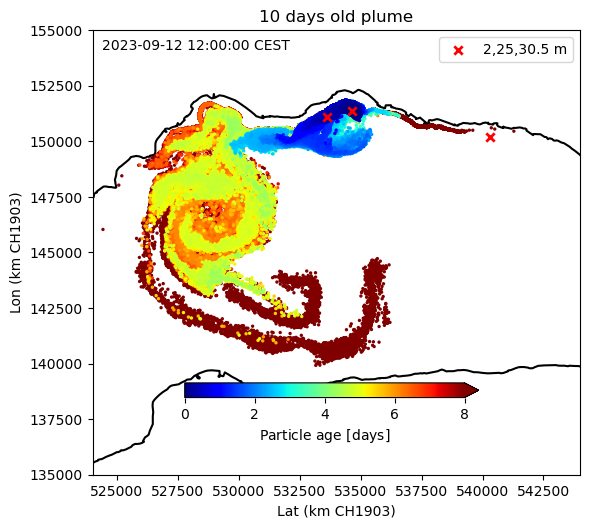

In [31]:
fig = plt.figure(figsize=(6,5.5))
plt.plot(xy_land[:,0], xy_land[:,1], color='black', zorder=1)

scatter = plt.scatter(x_inside, y_inside, 
                      c=age_inside, cmap='jet', s=2, vmin=0, vmax=8)

cbar = plt.colorbar(fraction=0.04,orientation="horizontal",pad=-0.25,extend='max')
cbar.set_label(label='$\mathregular{Particle \ age\ [days]}$')

#plt.scatter(x_sg_wwtp, y_sg_wwtp, color='r', zorder=4)
for label in meas_coordinates["label"].unique():
    subset = meas_coordinates[meas_coordinates["label"] == label]
    plt.scatter(subset["x"], subset["y"], label=label, marker='x', zorder=3, color=colors[label], linewidths=2)


plt.legend()
plt.title(plot_title)

#plt.xlim(526000,541000)
#plt.ylim(140000,155000)
plt.xlim(524000,544000)
plt.ylim(135000,155000)



plt.xlabel("Lat (km CH1903)")
plt.ylabel("Lon (km CH1903)")

plt.text(0.02, 0.98, f'{str_Bern_plot_date}', transform=plt.gca().transAxes, ha='left', va='top')
plt.tight_layout()
fig.savefig(plot_output_particles_path)

# Aggregate particles on the grid

### Get grid

In [37]:
r_seeding = 50 #[m]
A_seeding = math.pi * r_seeding**2
step = math.sqrt(A_seeding)
print(step)

88.6226925452758


In [38]:
#step = 200
conc_init = 2000 # particules / cellule

x_grid = np.arange(np.nanmin(x_inside), np.nanmax(x_inside), step)
y_grid = np.arange(np.nanmin(y_inside), np.nanmax(y_inside), step)

### Aggregate particles on grid

In [39]:
particle_concentration, x_edges, y_edges = np.histogram2d(x_inside, y_inside, bins=[x_grid,y_grid])
print(particle_concentration.max())
print(particle_concentration.min())
particle_concentration[particle_concentration == 0] = np.nan
particle_dispersion = particle_concentration / conc_init

9937.0
0.0


# Plot

In [43]:
from matplotlib.colors import LogNorm

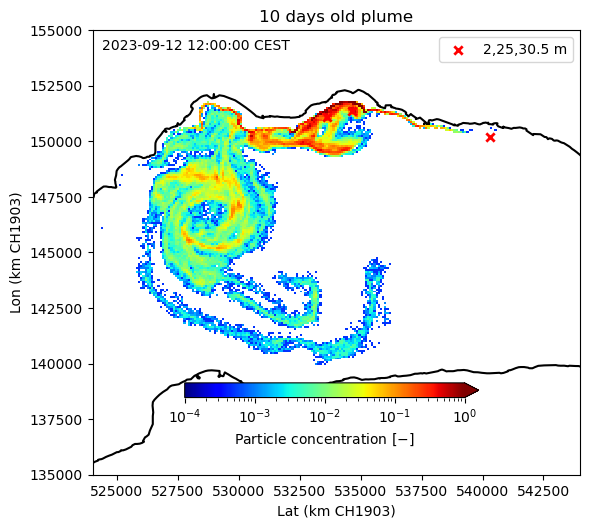

In [47]:
fig = plt.figure(figsize=(6,5.5))
# Lake contour
plt.plot(xy_land[:,0], xy_land[:,1], color='black', zorder=1)
# Particles concentration
plt.pcolormesh(x_edges, y_edges, particle_dispersion.T, cmap='jet', zorder=2, norm=LogNorm(vmin=1e-4, vmax=1))

cbar = plt.colorbar(fraction=0.04,orientation="horizontal",pad=-0.25,extend='max')
cbar.set_label(label='$\mathregular{Particle \ concentration\ [-]}$')

#plt.scatter(x_sg_wwtp, y_sg_wwtp, color='r', zorder=4)
# Sampling points
for label in meas_coordinates["label"].unique():
    subset = meas_coordinates[meas_coordinates["label"] == label]
    plt.scatter(subset["x"], subset["y"], label=label, marker='x', zorder=3, color=colors[label], linewidths=2)

plt.legend()
plt.title(plot_title)

#plt.xlim(526000,541000)
#plt.ylim(140000,155000)
plt.xlim(524000,544000)
plt.ylim(135000,155000)

plt.xlabel("Lat (km CH1903)")
plt.ylabel("Lon (km CH1903)")

plt.text(0.02, 0.98, f'{str_Bern_plot_date}', transform=plt.gca().transAxes, ha='left', va='top')
plt.tight_layout()
fig.savefig(plot_output_path)

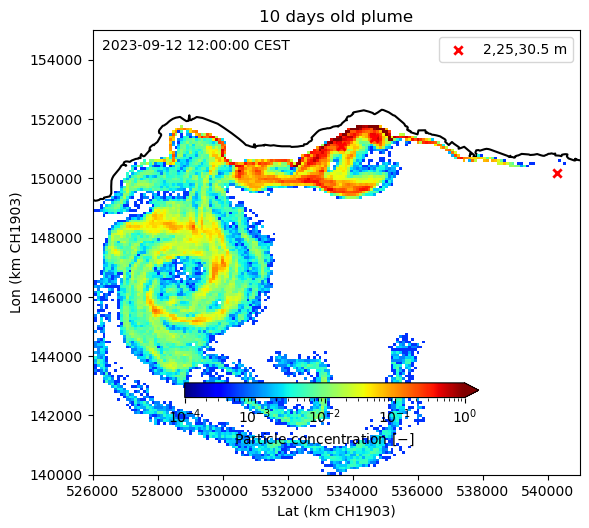

In [48]:
fig = plt.figure(figsize=(6,5.5))
plt.plot(xy_land[:,0], xy_land[:,1], color='black', zorder=1)
plt.pcolormesh(x_edges,y_edges, particle_dispersion.T, cmap='jet', zorder=2, norm=LogNorm(vmin=1e-4, vmax=1))

cbar = plt.colorbar(fraction=0.04,orientation="horizontal",pad=-0.25,extend='max')
cbar.set_label(label='$\mathregular{Particle \ concentration\ [-]}$')

#plt.scatter(x_sg_wwtp, y_sg_wwtp, color='r', zorder=4)
for label in meas_coordinates["label"].unique():
    subset = meas_coordinates[meas_coordinates["label"] == label]
    plt.scatter(subset["x"], subset["y"], label=label, marker='x', zorder=3, color=colors[label], linewidths=2)


plt.legend()
plt.title(plot_title)

plt.xlim(526000,541000)
plt.ylim(140000,155000)

plt.xlabel("Lat (km CH1903)")
plt.ylabel("Lon (km CH1903)")

plt.text(0.02, 0.98, f'{str_Bern_plot_date}', transform=plt.gca().transAxes, ha='left', va='top')
plt.tight_layout()
fig.savefig(plot_output_path_zoom)

In [49]:
plot_output_path_zoom

'.//figures//concentration//2023-09-12T10:00:00_10days_zoom.png'